# Welcome to SImulation of SEctoral Pathways with Uncertainty Exploration for DEcarbonization (SISEPUEDE)


https://sisepuede.readthedocs.io/en/latest/



In [1]:
## load packages
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import pandas as pd
import pathlib
import sys
import warnings
warnings.filterwarnings("ignore")

# import plotting elements
import sisepuede.plotting.plots as spl
import sisepuede.utilities._plotting as sup

# import key components
from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure



# First, we access the file structure to get the `ModelAttributes` object

- The `sisepuede_file_structure.SISEPUEDEFileStructure` object stores relevant paths and the general file structure of the entire system It's a key piece of the `SISEPUEDE` object; however, we can use it to look at the most important object in the ecosystem, the `ModelAttributes` object.

- Each subsector model relies on the `ModelAttributes` object to manage variables, categories, units (and associated conversions), and cross-sector interactions.

- Time periods are stored in the ModelAttributes object and are derived from the `attribute_dim_time_period.csv` attribue file. The current range runs from 0-35 (2015 to 2050), but this can be modified.


See the **`tutorial-1`** notebook for more on these objects.

In [2]:
# initialize a file structure and model attributes
file_struct = SISEPUEDEFileStructure()
model_attributes = file_struct.model_attributes

# We can instantiate an object that stores all models at once, but let's explore them one by one

- Every model object is callable and has a `project` method.
- Every model takes a DataFrame as input and returns a DataFrame as output.
- Use the `SISEPUEDEExamples` object to grab a tutorial data frame

In [3]:
# start with some example data
examples = SISEPUEDEExamples()
df_input = examples("input_data_frame")

##  Start with AFOLU

You can explore the arguments and keyword arguments using `?AFOLU` or `help(AFOLU)`

In [4]:
from sisepuede.models.afolu import AFOLU
?AFOLU

Init signature:
AFOLU(
    attributes: sisepuede.core.model_attributes.ModelAttributes,
    logger: Optional[logging.Logger] = None,
    npp_curve: Union[str, sisepuede.utilities._npp_curves.NPPCurve, NoneType] = None,
    npp_include_primary_forest: bool = False,
    npp_integration_windows: Union[list, tuple, numpy.ndarray] = [20, 480, 1000],
    **kwargs,
) -> None
Docstring:     
Use AFOLU to calculate emissions from Agriculture, Forestry, and Land Use 
    in SISEPUEDE. Includes emissions from the following subsectors:

    * Agriculture (AGRC)
    * Forestry (FRST)
    * Land Use (LNDU)
    * Livestock (LVST)
    * Livestock Manure Management (LSMM)
    * Soil Management (SOIL)

For additional information, see the SISEPUEDE readthedocs at:

    https://sisepuede.readthedocs.io/en/latest/afolu.html


Intialization Arguments
-----------------------
model_attributes : ModelAttributes
    ModelAttributes object used in SISEPUEDE to manage variables and 
    categories

Optional Argum

In [5]:
# initialize using only the model_attributes argument
model_afolu = AFOLU(model_attributes, )



##  You can project the model simply by calling it on the input data frame

In [6]:
df_out_afolu = model_afolu(df_input)

###  Visualize some output--e.g., start with **`Land Use Area`**

**NOTE**: The name of a variable--such as `Land Use Area` can be retrieved from the attribute tables on [Read the Docs](https://sisepuede.readthedocs.io)

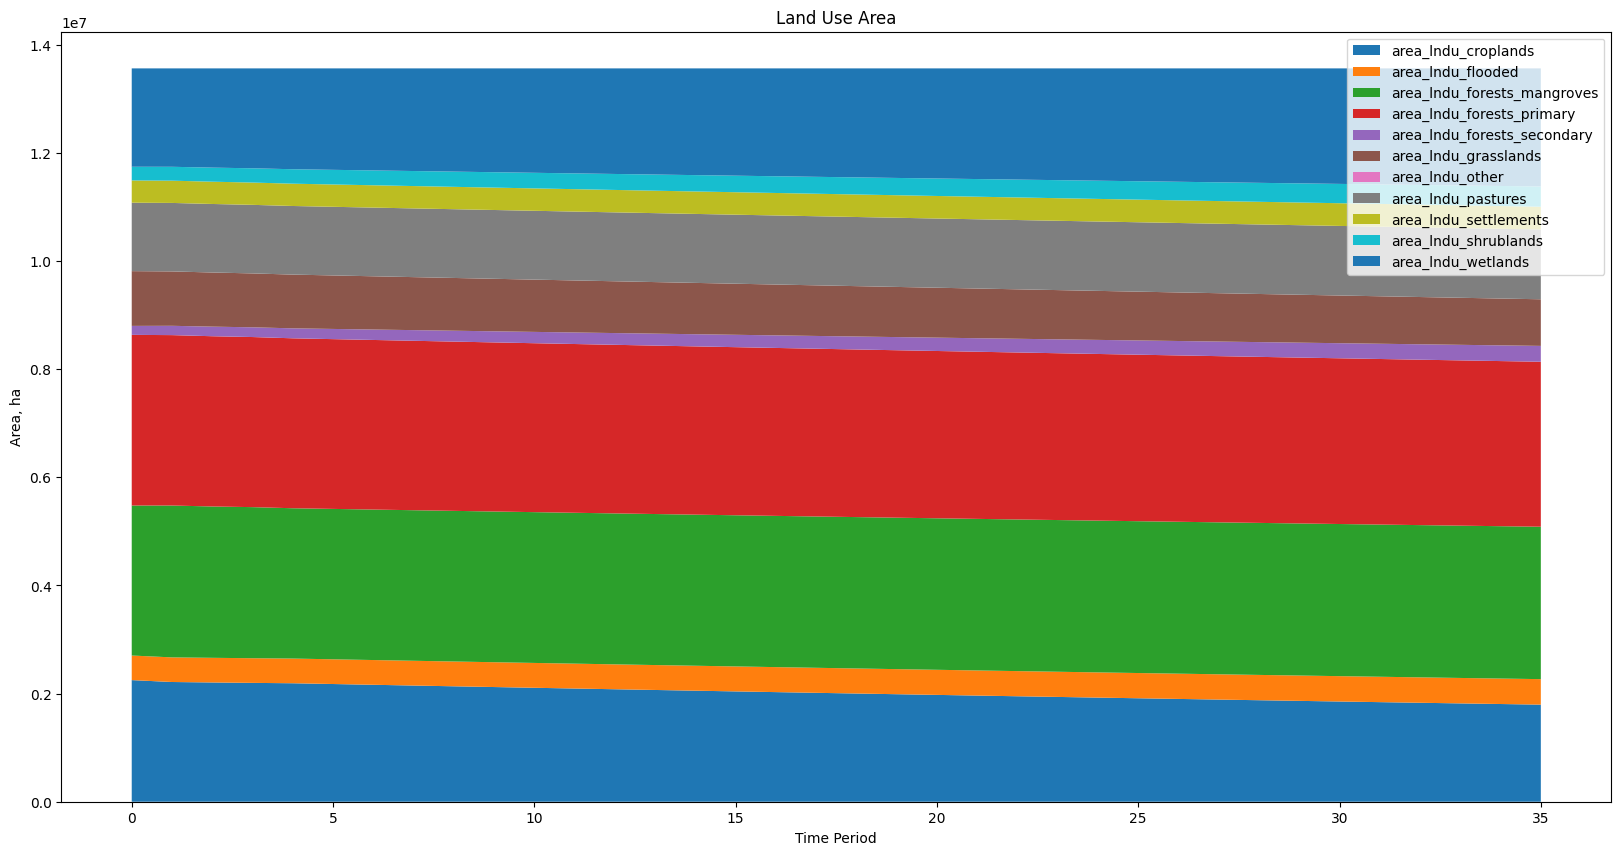

In [7]:
# retrieve ModelVariable for Land Use Area
modvar = model_attributes.get_variable("Land Use Area")

# format the figure
fig, ax = plt.subplots(figsize = (20, 10))

ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title(modvar.name)


spl.plot_variable_stack(
    df_out_afolu,
    modvar,
    model_attributes,
    figtuple = (fig, ax, ),
)

ax.legend(loc = "upper right")




###  Look at **`CO2 Emissions from Forest Biomass Sequestration`**

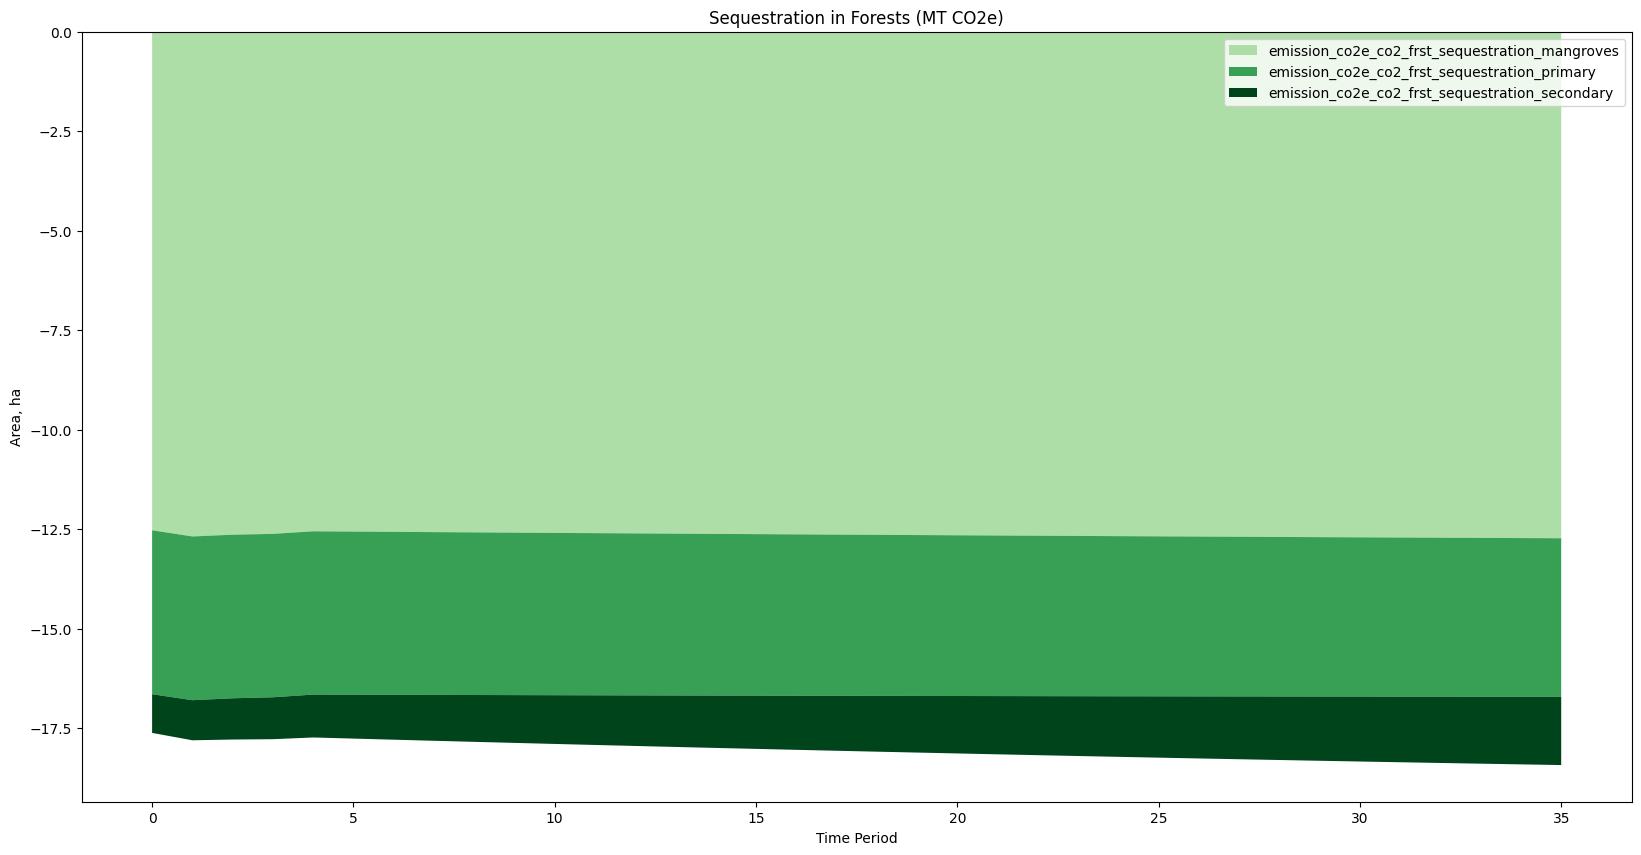

In [8]:
# get forest biomass sequestration
modvar = model_attributes.get_variable(":math:\\text{CO}_2 Emissions from Forest Biomass Sequestration")
fields = modvar.fields

# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title("Sequestration in Forests (MT CO2e)")

# optional info on setting colors
cmap = plt.colormaps["Greens"]#tab10
colors = [cmap(x/len(fields)) for x in range(1, len(fields) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),


spl.plot_variable_stack(
    df_out_afolu,
    modvar,
    model_attributes,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields)),
    figtuple = (fig, ax, ),
)

# set the legend
ax.legend(loc = "upper right")





##  Subsector total emissions for a single subsector can be accessed using `ModelAttributes.get_subsector_emission_total_field()`


In [9]:
# e.g., look at livestock aggregate CO2e emissions
model_attributes.get_subsector_emission_total_field("Livestock")

'emission_co2e_subsector_total_lvst'

##  Get all emission total fields associated with a sector using `model_attributes.get_sector_emission_total_fields()`

In [10]:
fields_subsector_total = model_attributes.get_sector_emission_total_fields("AFOLU")
fields_subsector_total

['emission_co2e_subsector_total_agrc',
 'emission_co2e_subsector_total_frst',
 'emission_co2e_subsector_total_lndu',
 'emission_co2e_subsector_total_lsmm',
 'emission_co2e_subsector_total_lvst',
 'emission_co2e_subsector_total_soil']

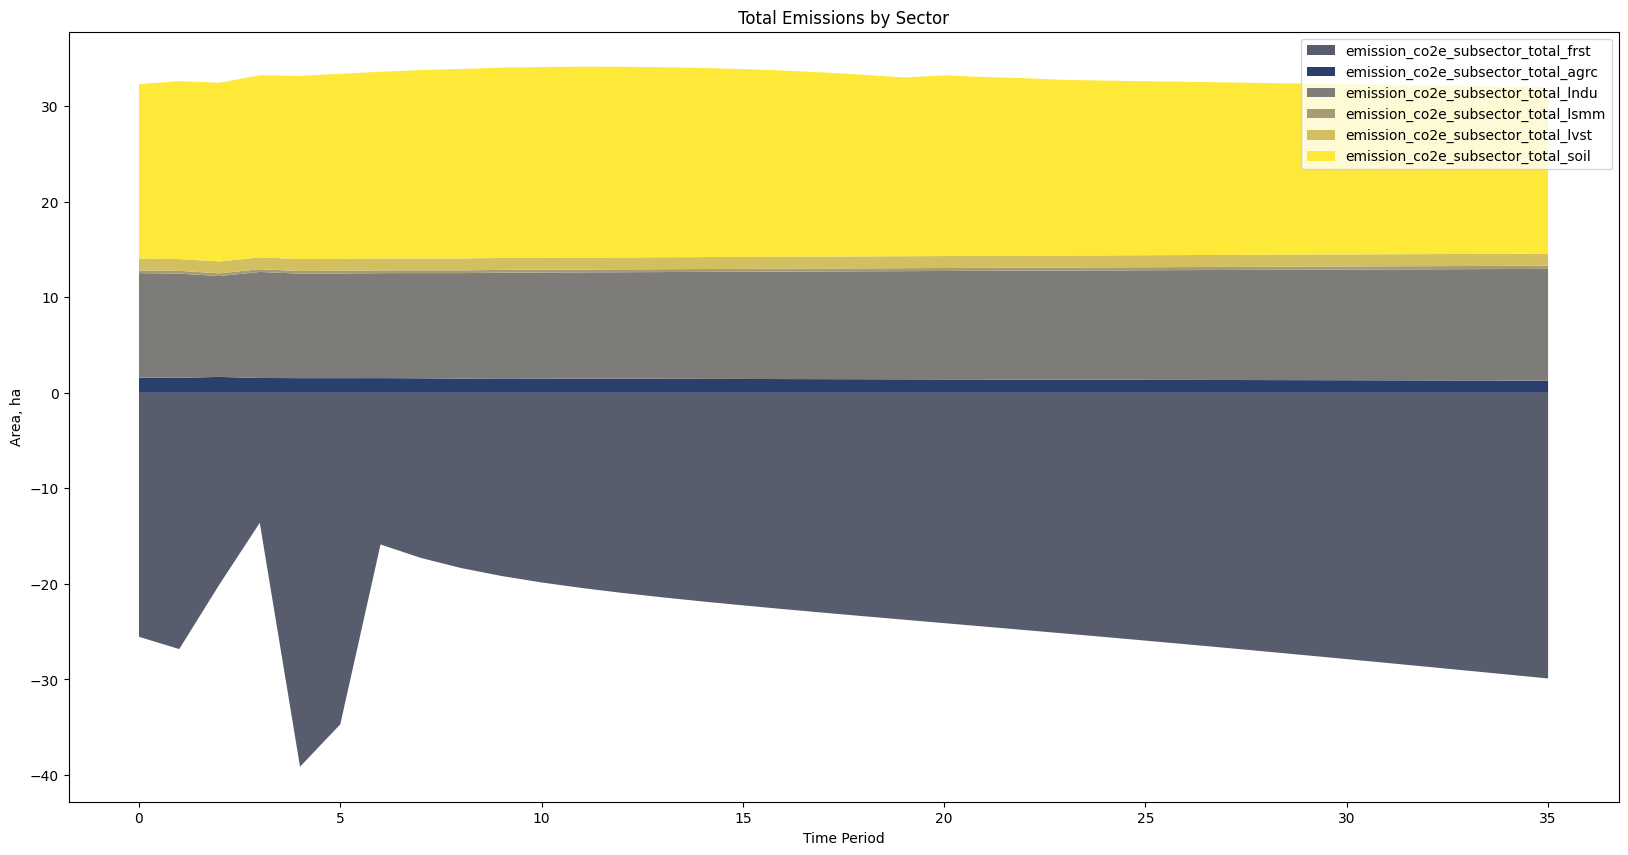

In [11]:
# setup figure
fig, ax = plt.subplots(figsize = (20, 10))
ax.set_xlabel("Time Period")
ax.set_ylabel("Area, ha")
ax.set_title("Total Emissions by Sector")


# can format 
cmap = plt.colormaps["cividis"]
colors = [cmap(x/len(fields_subsector_total)) for x in range(1, len(fields_subsector_total) + 1)]
dict_format = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),


sup.plot_stack(
    df_out_afolu,
    fields_subsector_total,
    dict_formatting = dict((x, {"color": colors[i] }) for i, x in enumerate(fields_subsector_total)),
    figtuple = (fig, ax),
)
ax.legend(loc = "upper right")

# Take a look at `CircularEconomy`

- **`CircularEconomy`** is dependent on **`AFOLU`** in the SISEPUEDE DAG, meaning that inputs depend on outputs from AFOLU when running integrated.
- However, we can run it independently without issue (for demonstration purposes)

In [12]:
from sisepuede.models.circular_economy import CircularEconomy


### Setup the object

In [ ]:
model_circecon = CircularEconomy(model_attributes, )

###  Run the `CircularEconomy` model

In [16]:
df_out_circecon = model_circecon(df_input)